In [1]:
%run '00_rh_settings.ipynb'

Populating the interactive namespace from numpy and matplotlib


In [2]:
ts_series=data.query("Stock == 'GOOG'")["Return"].dropna()

Подготовим две модели:
 * Первая будет повторять движение предыдущего дня
 * Вторая - ждать пока три дня движение было в одном направлении и затем его повторять

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin

In [4]:
class ReplicateYesterday(BaseEstimator, RegressorMixin):  
    """Made using: http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/"""

    def fit(self, X, y=None):
        return self

    def _predict_one(self, x):
        # # returns -1 / 0 or 1
        # prediction = 0
        # if x > 0:
        #     prediction = 1
        # if x == 0:
        #     prediction = 0
        # if x < 0:
        #     prediction = -1
        # return prediction
        return np.sign(x)

    def predict(self, X, y=None):
        return [self._predict_one(x) for x in pd.Series(X).shift(1)]

In [5]:
import collections

class ThreeInARow(BaseEstimator, RegressorMixin):  
    def fit(self, X, y=None):
        return self

    def predict(self, X, y=None):
        predictions = [None] * 3
        row = collections.deque(maxlen=3)
        for x in pd.Series(X).shift(1)[1:]:
            row.append(x)
            if len(row) == 3:
                #print(row)
                all_signs = np.sign(row)
                if len(set(all_signs)) == 1:
                    predictions.append(all_signs[0])
                else:
                    predictions.append(0)
        return predictions

In [6]:
model1 = ReplicateYesterday()
model2 = ThreeInARow()

## Profit-and-loss

In [7]:
def pnl(y_true, y_pred):
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).dropna()
    if len(df) < 1:
        raise ValueError("At least two obserbation")
    df["pnl"] = df["y_true"] * df["y_pred"]
    #df["hit"] = np.sign(df["y_true"]) == np.sign(df["y_pred"])
    #df["hit"] = df["hit"].astype(int)
    df["hit"] = np.sign(df["pnl"])
    #percent = (sum(abs(df["y_true"]))-abs(sum(df["pnl"])))/sum(abs(df["y_true"])
    percent = sum(df["pnl"])/ sum(abs(df["y_true"]))
    return df, percent

In [8]:
pnl(pd.Series([1,2,3]), [1,2,3])[0]

,y_pred,y_true,pnl,hit
0,1,1,1,1
1,2,2,4,1
2,3,3,9,1


## Hit rate scorer

0 - угадали в 0% случаев

1 - угадали в 100% случаев

In [9]:
from sklearn.metrics import make_scorer

In [15]:
def pnl_score_func(y_true, y_pred, **kwargs):
    if np.shape(y_true) != np.shape(y_pred):
        raise ValueError("Dimensions are different")

    df, percent = pnl(y_true, y_pred)
    #print(df)
    return percent
pnl_scorer = make_scorer(pnl_score_func)

Test of first model

In [16]:
# Test data
returns = [-2,1,2,1]
f_i = model1.predict(returns)

total_profit = [None, -1, 2, 1]
# metric of first model should be = 2/4
# metric of second should be zero
pnl_score_func(returns, model1.predict(returns))

0.5

Test of second model

In [17]:
test_data = [1,2,3,4,5,6,-1,-1-1,1,2,3,4]
len(test_data), len(test_data) == len(model2.predict(test_data)) == len(pd.Series(test_data).shift(1))
model2.predict(test_data)
pnl_score_func(returns, model2.predict(returns))

(12, True)

[None, None, None, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0]

0.0

# Prediction on GOOG

In [44]:
model1_df = pnl(ts_series, model1.predict(ts_series))[0]
model2_df = pnl(ts_series, model2.predict(ts_series))[0]

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


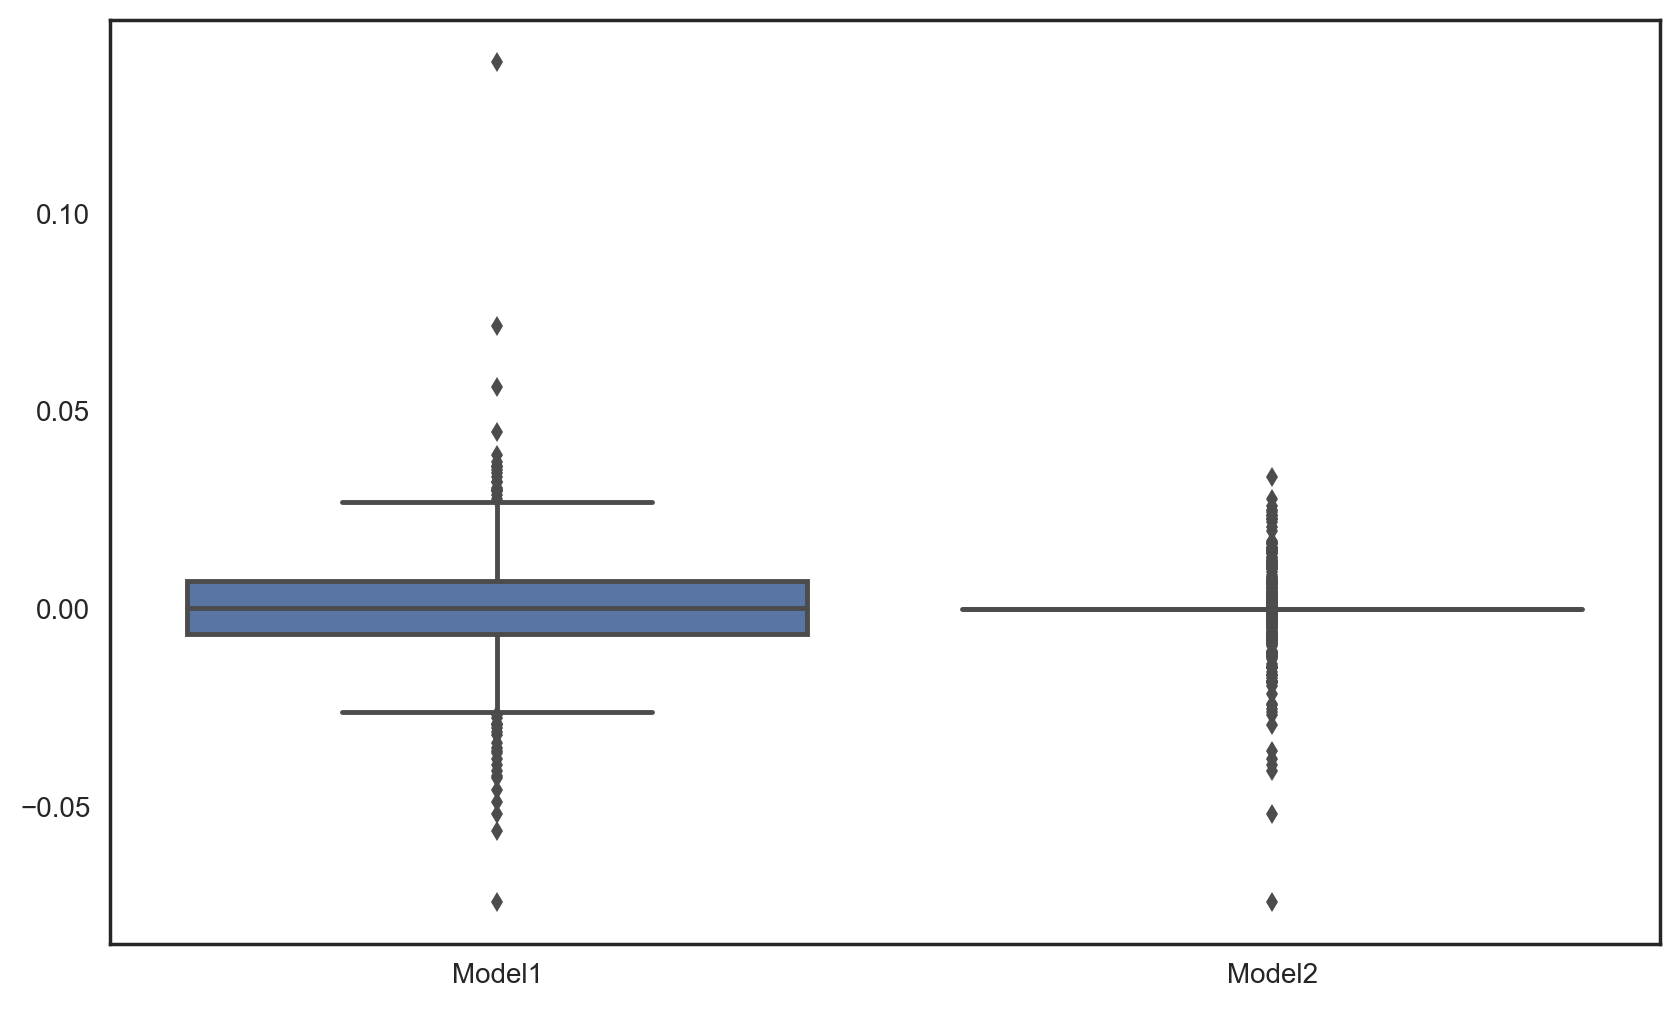

In [45]:
seaborn.boxplot(data=pd.DataFrame({"Model1": model1_df["pnl"], "Model2": model2_df["pnl"]}));

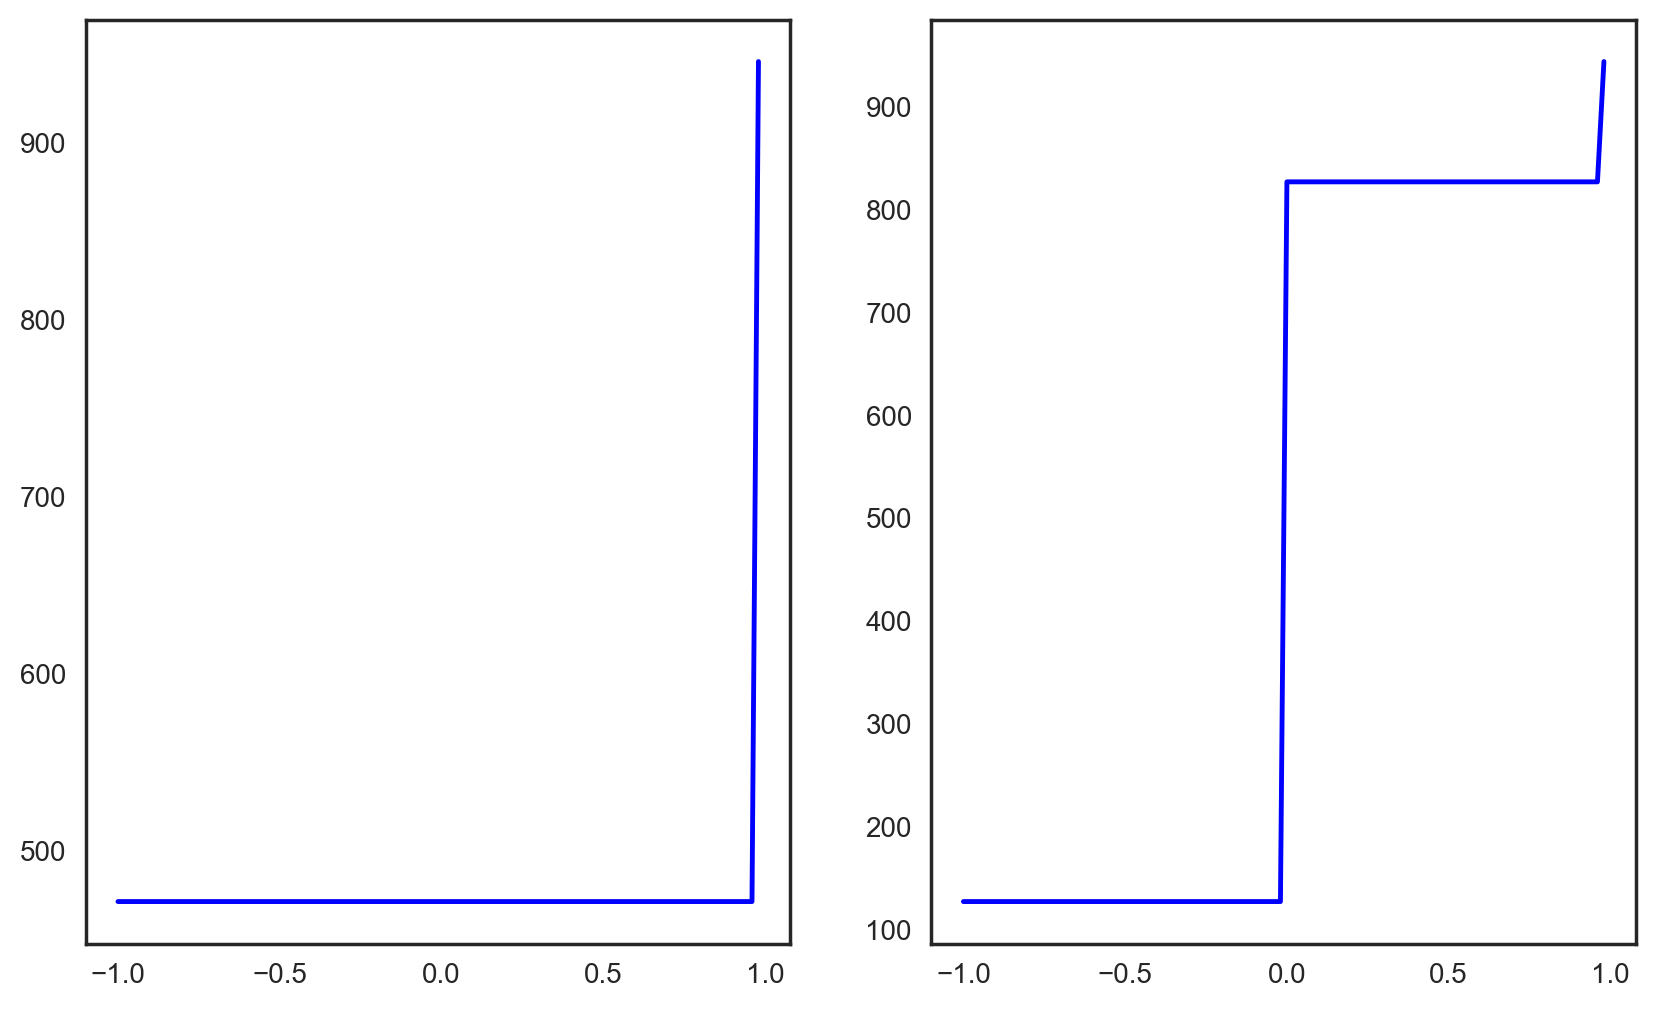

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(1,2,1)

data = model1_df["hit"]
# evaluate the histogram
values, base = np.histogram(data, bins=100)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

plt.subplot(1,2,2)

data = model2_df["hit"]
# evaluate the histogram
values, base = np.histogram(data, bins=100)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

plt.show()

In [46]:
model1_df["hit"].describe(), model2_df["hit"].describe()

(count    946.000000
 mean       0.004228
 std        1.000520
 min       -1.000000
 25%       -1.000000
 50%        1.000000
 75%        1.000000
 max        1.000000
 Name: hit, dtype: float64, count    944.000000
 mean      -0.010593
 std        0.508563
 min       -1.000000
 25%        0.000000
 50%        0.000000
 75%        0.000000
 max        1.000000
 Name: hit, dtype: float64)

In [47]:
predictions = pd.DataFrame({"model1_direction_pred": model1.predict(ts_series),
                      "model2_direction_pred": model2.predict(ts_series),
                      "true_direction": numpy.sign(ts_series)}).dropna()
predictions.head()

,model1_direction_pred,model2_direction_pred,true_direction
Date,,,
2014-04-02,-1.0,0.0,1.0
2014-04-03,1.0,0.0,-1.0
2014-04-04,-1.0,0.0,1.0
2014-04-07,1.0,0.0,1.0
2014-04-08,1.0,0.0,-1.0


## Sharpe ratio

$SR = E[pnl_i] / \sqrt{V[pnl_i]}$

In [48]:
sharpe_ratio = mean(model1_df["pnl"]) / std(model1_df["pnl"])

In [41]:
sharpe_ratio

0.007675573428036591

In [38]:
metrics = [sklearn.metrics.mean_squared_error, sklearn.metrics.mean_absolute_error, pnl_score_func]
for metric in metrics:
    print("%s for model is: %s" % (metric.__name__, metric(predictions["model1_pred"], predictions["true"])))

mean_squared_error for model is: 1.9872881355932204
mean_absolute_error for model is: 0.9936440677966102
pnl_score_func for model is: 0.006355932203389831
